## Loan default prediction using machine learning.

### Part 0. Initial preparation: 
* Removing duplicates;
* Test / Train stratified split. 

Dataset as found on Kaggle: https://www.kaggle.com/zaurbegiev/my-dataset

DataQubit, 2019

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_train = pd.read_csv('credit_train.csv')

In [3]:
df_train.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,14dd8831-6af5-400b-83ec-68e61888a048,981165ec-3274-42f5-a3b4-d104041a9ca9,Fully Paid,445412.0,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,NaN,6.0,1.0,228190.0,416746.0,1.0,0.0
1,4771cc26-131a-45db-b5aa-537ea4ba5342,2de017a3-2e01-49cb-a581-08169e83be29,Fully Paid,262328.0,Short Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,8.0,35.0,0.0,229976.0,850784.0,0.0,0.0
2,4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,5efb2b2b-bf11-4dfd-a572-3761a2694725,Fully Paid,99999999.0,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,29.0,18.0,1.0,297996.0,750090.0,0.0,0.0
3,77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,e777faab-98ae-45af-9a86-7ce5b33b1011,Fully Paid,347666.0,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,NaN,9.0,0.0,256329.0,386958.0,0.0,0.0
4,d4062e70-befa-4995-8643-a0de73938182,81536ad9-5ccf-4eb8-befb-47a4d608658e,Fully Paid,176220.0,Short Term,NaN,NaN,5 years,Rent,Debt Consolidation,20639.70,6.1,NaN,15.0,0.0,253460.0,427174.0,0.0,0.0


In [4]:
df_train['Loan Status'].unique()

array(['Fully Paid', 'Charged Off', nan], dtype=object)

This dataset is somewhat imbalanced (as you can see in the plot below). But we will deal with it later when start doing modelling.

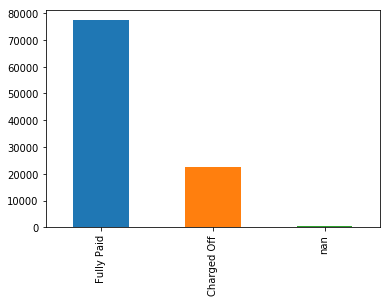

In [7]:
df_train['Loan Status'].value_counts(dropna=False).plot(kind='bar')

### Removing Duplicates

In [8]:
len(df_train['Loan ID'].unique()), len(df_train['Customer ID'].unique()), len(df_train)

(82000, 82000, 100514)

In [9]:
df_train = df_train.drop_duplicates()

There are still some duplicate ids after removal of identical rows:

In [10]:
df_train['Customer ID'].value_counts().head()

bc89f7d9-b603-41ee-9497-a40752183ae9    2
d6220104-f50b-416a-a087-f362cc4dd2d6    2
c61aa9af-f83a-4828-bd50-5f5381a25b20    2
f710c709-9220-498a-a007-49e486f4225b    2
3949fa33-d532-41dc-9e9f-a721c62bf6fd    2
Name: Customer ID, dtype: int64

And it is a bit harder than just removing identical duplicate rows, because these two rows per unique customer ID are different, and sometimes you need to keep the one with valid `Current Loan Amount` (less than noisy value of 99999999.0), and sometimes you need to remove the row of multiple NaN values. We handle these two cases below:

First, let's create an array containing duplicated customer IDs:

In [11]:
val_counts = df_train['Customer ID'].value_counts()
duplicate_customer_ids = val_counts[val_counts > 1].index

In [12]:
len(duplicate_customer_ids)

7786

Second, let's compute loan amounts for duplicate ids.
We gonna use it to choose rows among duplicated cases.

In [13]:
loan_amounts = [df_train[df_train['Customer ID'] == duplicate_id]['Current Loan Amount']
               for duplicate_id in duplicate_customer_ids]

Then, number of missing values in the customer id row for duplicate customer IDs will also be useful for accurate row removal.

In [14]:
# number of missing values in the customer id row
nan_counts = [df_train[df_train['Customer ID'] == duplicate_id].isnull().sum(axis=1)
               for duplicate_id in duplicate_customer_ids]

Now we are ready to create a list of indexes that need to be selected among duplicates:

In [15]:
# creating list of indexes that need to be selected among duplicates
prefered_ixs = []
for loan_amount, nan_count in zip(loan_amounts, nan_counts):
    if (loan_amount < 99999999.0).astype(int).diff().iloc[1] == -1. or nan_count.diff().iloc[1] > 0:
        prefered_index = loan_amount.index[0]
    elif (loan_amount < 99999999.0).astype(int).diff().iloc[1] == 1. or nan_count.diff().iloc[1] < 0:
        prefered_index = loan_amount.index[1]
    prefered_ixs.append(prefered_index)

In [16]:
# sanitary check
len(prefered_ixs), len(duplicate_customer_ids)

(7786, 7786)

Another sanitary check of some of the prefered indexes:

In [17]:
df_train.loc[prefered_ixs[0:3]]

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
98981,7f85733b-ef51-48e5-a0a2-1a7b68492d4e,bc89f7d9-b603-41ee-9497-a40752183ae9,Fully Paid,261514.0,Short Term,701.0,3576066.0,4 years,Home Mortgage,Debt Consolidation,24466.30,16.6,26.0,11.0,0.0,626107.0,780362.0,0.0,0.0
75925,b264998e-5811-47b2-b725-cbe1ebbf0d36,d6220104-f50b-416a-a087-f362cc4dd2d6,Fully Paid,210694.0,Short Term,677.0,967860.0,2 years,Rent,Other,1177.43,11.8,42.0,3.0,0.0,90972.0,204160.0,0.0,0.0
99196,2e8dcad4-4fa1-43dc-ab11-e52b9b9ec36e,c61aa9af-f83a-4828-bd50-5f5381a25b20,Fully Paid,228536.0,Short Term,713.0,972230.0,10+ years,Home Mortgage,Debt Consolidation,27708.65,17.2,4.0,19.0,0.0,115995.0,236456.0,0.0,0.0


Finally, we can create the non-duplicated set:

In [18]:
# new non-duplicate set is a combination of original dataframe without duplicate ids and prefered indexes 
df_loan_nondup = pd.concat([df_train[~df_train['Customer ID'].isin(duplicate_customer_ids)], 
                            df_train.loc[prefered_ixs]])

In [19]:
len(df_loan_nondup)

82000

Let's confirm it does not have duplicated customer IDs anymore:

In [20]:
len(df_loan_nondup['Customer ID'].unique()), len(df_loan_nondup['Loan ID'].unique())

(82000, 82000)

Again, this is an example of what we have just fixed:

In [21]:
df_train[df_train['Customer ID'] == duplicate_customer_ids[4]]

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
37710,84811511-5096-4a26-adec-b81377f2d47d,3949fa33-d532-41dc-9e9f-a721c62bf6fd,Fully Paid,331496.0,Long Term,702.0,1908550.0,10+ years,Home Mortgage,Debt Consolidation,27181.02,20.5,NaN,14.0,0.0,557346.0,1450240.0,0.0,0.0
87128,84811511-5096-4a26-adec-b81377f2d47d,3949fa33-d532-41dc-9e9f-a721c62bf6fd,Fully Paid,331496.0,Long Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,27181.02,20.5,NaN,14.0,0.0,557346.0,1450240.0,0.0,0.0


### Creating Holdout Test set

In this section, we create a holdout test set, that we will use eventually to evaluate the final models (but not during the model exploration phase).

Since our dataset is highly imbalanced (there are much more successfully paid loans than defaulted ones), our test set should have a similar proportion of both classes. 

In [22]:
class_counts = df_loan_nondup['Loan Status'].value_counts(dropna=False)

In [23]:
class_counts

Fully Paid     59360
Charged Off    22639
NaN                1
Name: Loan Status, dtype: int64

Let's create an index set for the holdout test set by taking approximately 10 % of every class proportionally:

In [24]:
# stratified sampling according to class imbalance
np.random.seed(2019)
test_index_fully_paid = np.random.choice(df_loan_nondup[df_loan_nondup['Loan Status']=='Fully Paid'].index,
                                  size=int(class_counts['Fully Paid'] * 0.1), replace=False)
test_index_charged_off = np.random.choice(df_loan_nondup[df_loan_nondup['Loan Status']=='Charged Off'].index,
                                  size=int(class_counts['Charged Off'] * 0.1), replace=False)

In [25]:
test_index = np.concatenate([test_index_fully_paid, test_index_charged_off])

In [26]:
df_loan_test = df_loan_nondup.loc[test_index]

In [27]:
df_loan_train = df_loan_nondup.loc[~df_loan_nondup.index.isin(test_index)]

In [28]:
len(df_loan_train), len(df_loan_test)

(73801, 8199)

Let's make sure we don't have overlaps:

In [29]:
set(df_loan_train['Customer ID']).intersection(df_loan_test['Customer ID'])

set()

Save both datasets for future use:

In [ ]:
df_loan_test.to_csv('train_test_data_nondup/df_loan_test.csv', index=None)
df_loan_train.to_csv('train_test_data_nondup/df_loan_train.csv', index=None)

We will do more exciting stuff in the next notebooks!